In [54]:
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf

from transformers import XLMRobertaTokenizer, TFXLMRobertaModel

from transformers import TFXLMRobertaModel
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [45]:
train_data = pd.read_csv(r"/content/train.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)
val_data = pd.read_csv(r"/content/validation.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)
test_data = pd.read_csv(r"/content/test.csv", header=None, names=['id', 'text', 'labels'], skiprows=1)

In [46]:
train_data.head()

,id,text,labels
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive"
1,2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,non-hostile
2,3,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील...",non-hostile
3,4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive"
4,5,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स...,non-hostile


In [47]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\w+", "", text)  # Remove URLs and mentions
    text = re.sub(r"[^\u0900-\u097F\s]+", "", text)  # Remove non-Devanagari chars
    return text.strip()

# Clean the text in all datasets
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
val_data['cleaned_text'] = val_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

In [48]:
# Map multi-labels to single labels
label_mapping = {
    "defamation": "defamation",
    "hate": "hate",
    "offensive": "offensive",
    "fake": "fake",
    "non-hostile": "non-hostile"
}
train_data['single_label'] = train_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))
val_data['single_label'] = val_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))
test_data['single_label'] = test_data['labels'].apply(lambda x: label_mapping.get(x.split(',')[0], 'unknown'))

In [49]:
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['single_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['single_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['single_label'])

In [50]:
# Load XLM-RoBERTa tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [51]:
max_length = 128

In [55]:
# Preprocessing function for tokenization (reuse your original preprocessing code)
def preprocess_data(texts, labels, tokenizer, max_length):
    encodings = tokenizer(
        texts,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return encodings, tf.convert_to_tensor(labels)

# Preprocess data
train_encodings, train_labels = preprocess_data(train_data['cleaned_text'].tolist(), train_data['encoded_labels'].tolist(), tokenizer, max_length)
val_encodings, val_labels = preprocess_data(val_data['cleaned_text'].tolist(), val_data['encoded_labels'].tolist(), tokenizer, max_length)
test_encodings, test_labels = preprocess_data(test_data['cleaned_text'].tolist(), test_data['encoded_labels'].tolist(), tokenizer, max_length)

In [56]:
class CustomXLMRoberta(tf.keras.Model):
    def __init__(self, num_labels):
        super(CustomXLMRoberta, self).__init__()

        # Load XLM-RoBERTa base model
        self.xlm_roberta = TFXLMRobertaModel.from_pretrained('xlm-roberta-base')

        # Additional classification layers
        self.classifier = tf.keras.Sequential([
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dense(32, activation='relu'),
            Dense(num_labels, activation='softmax')
        ])

    def call(self, inputs):
        # XLM-RoBERTa outputs
        input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
        xlm_roberta_output = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Get CLS token output (batch_size, hidden_size)
        cls_output = xlm_roberta_output.last_hidden_state[:, 0, :]

        # Pass through the classifier layers
        output = self.classifier(cls_output)

        return output

In [57]:
# Initialize the model
num_labels = len(label_encoder.classes_)
model = CustomXLMRoberta(num_labels)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [59]:
# Set optimizer and compile the model
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(32)

In [61]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 88s 163ms/step - accuracy: 0.4065 - loss: 1.5533 - val_accuracy: 0.5364 - val_loss: 1.3694
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - accuracy: 0.5377 - loss: 1.3497 - val_accuracy: 0.5364 - val_loss: 1.3099
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.5377 - loss: 1.3070 - val_accuracy: 0.5364 - val_loss: 1.2968
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.5377 - loss: 1.2972 - val_accuracy: 0.5364 - val_loss: 1.2924
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.5377 - loss: 1.2932 - val_accuracy: 0.5364 - val_loss: 1.2890
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.5377 - loss: 1.2899 - val_accuracy: 0.5364 - val_loss: 1.2856
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.5377 - loss: 1.2866 - val_accuracy: 0.5364 - val_loss: 1.2820
Epoch 8/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.5377 - loss: 1

In [62]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step - accuracy: 0.6173 - loss: 0.9713
Test Accuracy: 0.6394


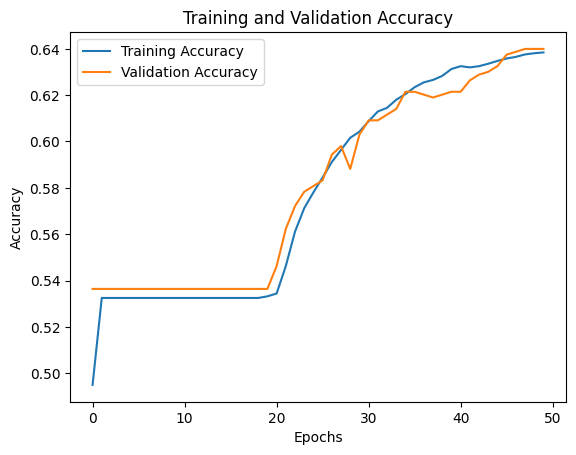

In [63]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Extract accuracy values from training history
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot the training and validation accuracy
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Call the function after training
plot_accuracy(history)


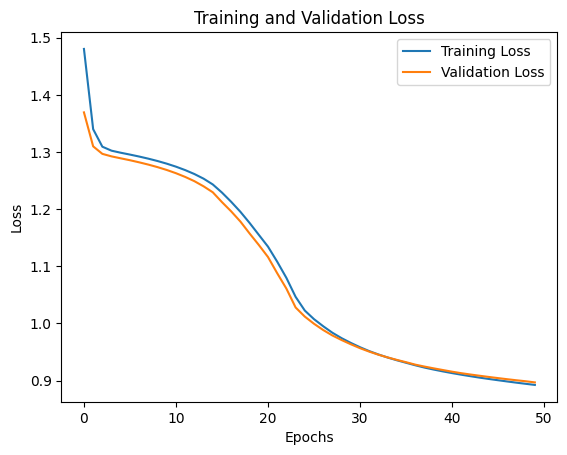

In [64]:
def plot_loss(history):
    # Extract loss values from training history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training and validation loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function after training
plot_loss(history)

In [43]:
# # Example prediction function
# def predict_hostility(text):
#     embedding = get_bert_embeddings(text)
#     prediction = model.predict(embedding)
#     predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
#     return predicted_label

In [ ]:
# # Example usage
# example_text = "कंगना रनौत के अवैध ऑफिस के लिए हाइकोर्ट्स के पास टाइम ही टाइम है लेकिन संजीव भट्ट , डॉ कफील , उमर खालिद पर होने वाली तानाशाही…"
# print(f"Predicted Label: {predict_hostility(example_text)}")
